In [1]:
%load_ext autoreload
%autoreload

import sys

sys.path.append("../../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../fit/")
import synthetic

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np


import analyze_synthetic
import utils

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/scripts/analysis/../../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

seed = 123
rng = np.random.default_rng(seed)
prng_state = jr.PRNGKey(seed)
batch_size = 10000

## Data

In [9]:
### data ###
data_path = "../../data/synthetic/"
session_name = "syn_data_seed123"
max_ISI_order = 4

select_fracs = [0.0, 1.0]

dataset_dict = synthetic.spikes_dataset(session_name, data_path, max_ISI_order, select_fracs)

#covariates = dataset_dict['covariates']
#x_t, y_t = covariates['x'], covariates['y']


In [5]:
ISI_order = 4
reg_config_names = [
    'syn_data_seed123ISI4sel0.0to1.0_PP-log__factorized_gp-16-1000_X[x-y]_Z[]', 
    'syn_data_seed123ISI4sel0.0to1.0_isi4__nonparam_pp_gp-48-matern32-matern32-1000-n2._' + \
    'X[x-y]_Z[]_freeze[obs_model0log_warp_tau]', 
]

tuning_model_name = reg_config_names[-1]

checkpoint_dir = '../checkpoint/'

In [13]:
regression_dict = utils.evaluate_regression_fits(
    checkpoint_dir, reg_config_names, synthetic.observed_kernel_dict_induc_list, 
    dataset_dict, [], rng, prng_state
)

Analyzing regression for syn_data_seed123ISI4sel0.0to1.0_PP-log__factorized_gp-16-1000_X[x-y]_Z[]...
Training data...


  0%|          | 0/2 [00:00<?, ?it/s]

2023-04-30 08:06:25.143116: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2432] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: Unable to launch triangular solve.


XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: Unable to launch triangular solve.

In [36]:
tuning_dict = analyze_synthetic.tuning(
    checkpoint_dir, tuning_model_name, dataset_dict, rng, prng_state, batch_size
)

Analyzing tuning for syn_data_seed123ISI4sel0.0to1.0_isi4__nonparam_pp_gp-48-matern32-1000-2._X[x-y]_Z[]...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
tuning_dict.keys()

dict_keys(['pos_x_locs', 'pos_isi_locs', 'pos_mean_ISI', 'pos_CV_ISI', 'ISI_t_eval', 'ISI_deltas_conds', 'ISI_xs_conds', 'ISI_densities', 'warp_tau', 'len_tau', 'len_deltas', 'len_xs'])

In [8]:
import matplotlib.pyplot as plt
plt.style.use(['../plots/paper.mplstyle'])

In [9]:
ts = 3000
dt = 0.001
p = 0.003
spikes_at = rng.binomial(1, p, size=(ts,))
spike_times = np.where(spikes_at > 0)[0]

time_t = np.arange(ts) * dt
rates_t = 30. * (np.sin(time_t * (1 + np.exp( -1.5 * (time_t - time_t[-1]/2.) ** 2 )))**2 + \
    np.exp( -0.5 * (time_t - time_t[-1]/3.) ** 2 ))


rtime_t = np.cumsum(rates_t * dt)
rspike_times = np.ceil(rtime_t[spike_times] / dt).astype(int)

In [13]:
tuning_dict['warp_tau']

array([  3.0087075,  60.18738  ,  42.552933 , 162.53026  ,   2.6303558,
         1.9249934,  42.967896 ,  37.357735 ,   8.848629 ], dtype=float32)

In [17]:
dataset_dict['ISIs'][:, 0, 0]

array([0.172, 0.173, 0.174, ..., 0.053, 0.054, 0.055])

In [11]:
sys.path.append("../../data/synthetic")
import generate

mdl = generate.model('Gaussian')
ratefunc, N = mdl.get_model()

# rates
xlist = [np.linspace(0, 500, 100), np.linspace(0, 500, 100)]
x_dims = len(xlist)

xx = np.meshgrid(*xlist)
xx = jnp.stack(xx, axis=-1)

or_shape = xx.shape[:-1]
xx = xx.reshape(-1, x_dims)  # (evals, x_dim)

rates = jax.vmap(ratefunc)(xx)
rates = rates.reshape(*or_shape, -1)

In [ ]:
# each cell has unique colour
# no rate rescaling
A
# ground truth cells, bottom : renewal densities
B 
# fitted rate maps from models
# maybe plot: Poisson rates too
# posterior samples
C
# qq plots

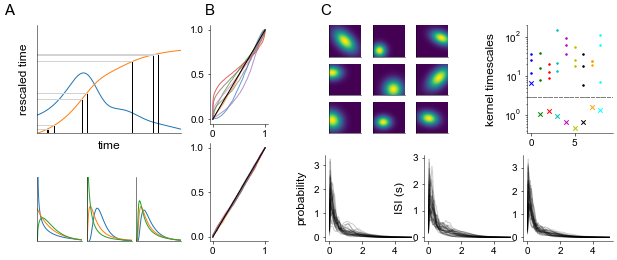

In [45]:
fig = plt.figure(figsize=(8, 3))
fig.set_facecolor('white')

fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.3, 1.05, 'B', fontsize=15, ha='center')
fig.text(0.5, 1.05, 'C', fontsize=15, ha='center')


### rate rescaling ###
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.0, right=0.25, wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

ax.plot(time_t, rates_t)
ax.plot(time_t, rtime_t)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('time')
ax.set_ylabel('rescaled time')

ax.set_xlim([time_t[0], time_t[-1]])
ax.set_ylim([rtime_t[0], 1.3*rtime_t[-1]])
for st, rst in zip(spike_times, rspike_times):
    ax.plot(np.ones(2)*st*dt, [0., rtime_t[st]], c='k')
    ax.plot([0., time_t[st]], np.ones(2)*rst*dt, c='lightgray')


widths = [1, 1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.3, bottom=0.0, 
                        left=0.0, right=0.25, wspace=0.1)

ISI = jnp.linspace(1e-12, 3., 100)[:, None]

for en, rtype in enumerate(['gamma', 'lognorm', 'invgauss']):
    rm, _ = generate.get_renewal(rtype, 3, dt)
    ll = jax.vmap(rm.log_density)(ISI)
    
    ax = fig.add_subplot(spec[0, en])
    ax.plot(ISI, np.exp(ll)[:, :])
    ax.set_xlim([0, ISI[-1]])
    ax.set_ylim([0, 2.])
    ax.set_xticks([])
    ax.set_yticks([])
    
    
### KS statistics ###
widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.3, right=0.4, wspace=0.1)

for en, n in enumerate(reg_config_names):
    ax = fig.add_subplot(spec[en, 0])

    dd = regression_dict[n]
    sort_cdfs = dd['KS_quantiles']

    for n in range(len(sort_cdfs)):
        if sort_cdfs[n] is not None:
            ax.plot(np.linspace(0., 1., len(sort_cdfs[n])), sort_cdfs[n], alpha=0.7)
    ax.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')


### tuning curves ###
widths = [1] * 3
heights = [1] * 3
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.5, right=0.72, wspace=0.1)

for n in range(3):
    for m in range(3):
        k = 3*n + m
        ax = fig.add_subplot(spec[n, m])

        ax.imshow(rates[..., k], extent=[xlist[0][0], xlist[0][-1], xlist[1][0], xlist[1][-1]], 
                  origin='lower', cmap='viridis')
        ax.set_xlim([xlist[0][0], xlist[0][-1]])
        ax.set_ylim([xlist[1][0], xlist[1][-1]])
        ax.set_xticks([])
        ax.set_yticks([])
        

ax.annotate("", xy=(1.35, -0.2), xytext=(1.35, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.6, head_length=1.0, tail_width=0.5", color='gray'), 
    annotation_clip=False)

ax.annotate("", xy=(1.35, -0.2), xytext=(1.35, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.6, head_length=1.0, tail_width=0.5", color='gray'), 
    annotation_clip=False)

ax.annotate("", xy=(1.35, -0.2), xytext=(1.35, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.6, head_length=1.0, tail_width=0.5", color='gray'), 
    annotation_clip=False)


### conditional ISI distributions ###
widths = [1, 1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.4, bottom=0.0, 
                        left=0.5, right=1.0, wspace=0.1)   
    
t_eval = tuning_dict['ISI_t_eval']
ne = 5
loc_inds = [0, 3, 5]
for en, loc_ind in enumerate(loc_inds):
    ax = fig.add_subplot(spec[0, en])
    dens = tuning_dict['ISI_densities'][loc_ind, :, ne, :]
    ax.plot(t_eval, dens.T, c='k', alpha=0.2)
    
    if en == 0:
        ax.set_ylabel('probability')
    elif en == 1:
        ax.set_ylabel('ISI (s)')
        
        
        
    
### kernel lengthscales ###
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.85, right=1.0, wspace=0.1)

ls = tuning_dict['len_deltas']
tls = tuning_dict['len_tau']
cs = [
    'b',
    'g',
    'r',
    'c',
    'm',
    'y',
    'k',
    'orange',
    'cyan'
]

ax = fig.add_subplot(spec[0, 0])
for n in range(9):
    lens = ls[n]
    tlen = tls[n]
    ax.scatter(n*np.ones_like(lens), lens, marker='.', c=cs[n])
    ax.scatter(n*np.ones(1), tlen, marker='x', c=cs[n], s=20)
    ax.set_yscale('log')
    ax.set_ylabel('kernel timescales')
    ax.plot([-.5, 9.5], 3. * np.ones(2), '--', color='gray')
    ax.set_xlim([-.5, 9.5])
    
        
        
        
#plt.savefig('../saves/synthetic.pdf')
plt.show()